In [1]:
import pandas as pd

raw = pd.read_csv('smartlab.csv')
ok_cols = [col for col in raw if all(raw[col] != '-')]
ds = raw[ok_cols]

ds.head()

/home/paii/.local/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,label,0C:80:63:2F:3F:42,0C:80:63:2F:3C:15,EC:3C:BB:87:4A:12,D2:32:4B:6B:49:E3,0C:80:63:2F:3C:14,0C:80:63:2F:3C:38,0C:80:63:2F:3F:41
0,a,-54,-45,-61,-53,-39,-78,-59
1,a,-57,-45,-51,-46,-39,-72,-51
2,a,-58,-45,-62,-47,-46,-66,-54
3,a,-51,-41,-57,-59,-46,-66,-54
4,a,-57,-43,-61,-59,-42,-60,-52


In [2]:
labels = list(ds['label'])
{label: labels.count(label) for label in set(labels)}

{'b': 23, 'd': 27, 'c': 25, 'a': 22}

In [43]:
from sklearn.model_selection import train_test_split

x = ds[[col for col in ok_cols if col != 'label']]
y = ds["label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [44]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

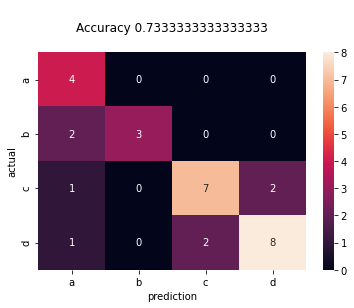

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

%matplotlib inline

sns.heatmap(
    pd.crosstab(
        y_test,
        y_pred,
        rownames=["actual"],
        colnames=["prediction"],
    ),
    annot=True,
)

accuracy = metrics.accuracy_score(y_test, y_pred)
plt.title(f"\nAccuracy {accuracy}\n")

plt.show()

In [64]:
from src.iwlist import Scanner

scanner = Scanner("wlo1")
cells = scanner.parse(scanner.call())

cells = {cell.mac: cell.signal_level for cell in cells}
cells

{'0C:80:63:2F:3F:42': '-55',
 '64:59:F8:06:5B:F8': '-89',
 '66:D6:E6:E7:97:64': '-71',
 'EC:3C:BB:87:4A:12': '-57',
 'D2:32:4B:6B:49:E3': '-51',
 '82:C9:4E:7F:14:3B': '-49',
 '24:A4:3C:95:88:6A': '-82',
 '0C:80:63:2F:3F:41': '-57',
 '0C:80:63:2F:3C:38': '-73',
 '44:D9:E7:C7:0C:85': '-84',
 '0C:80:63:2F:3C:39': '-67',
 '0C:80:63:2F:3C:15': '-54',
 '46:A4:3C:95:88:6A': '-83',
 '0C:80:63:2F:3C:14': '-37'}

In [65]:
signals = [mac for mac in cells if mac in ok_cols]
signals = [cells[mac] for mac in ok_cols if mac in signals]
prediction = clf.predict([signals])

*prediction, signals

('a', ['-55', '-54', '-57', '-51', '-37', '-73', '-57'])